<br>
<p><font size="24">MODELLING SWISS VOTATION OUTCOMES</font></p><br>
<p><font size="12">Coursera Capstone Report for the IBM Professional Certificate in Data Science</font></p><br>
Juliane Klatt
<hr>
<h2>Table of Contents</h2>
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#data">Data</a></li>
        <ol type="1">
            <li><a href="#pleb">Swiss Plebiscite Data</a></li>
            <li><a href="#mun">List of Swiss Municipalities</a></li>
            <li><a href="#four">Foursquare Location Data</a></li>
        </ol>
    <li><a href="#meth">Methodology</a></li>
    <li><a href="#res">Results</a></li>
    <li><a href="#con">Conclusion</a></li>
    <li><a href="#ref">References</a></li>
</ol>

<a id='intro'></a>
<hr>
<h2>Introduction</h2>
<p>In Switzerland, plebiscites at federal, cantonal, and municipal level are a central feature of political life. It is not the government's choice whether or when a referendum is held, but it is a legal procedure regulated by the Swiss constitution. There are two types of referendums: optional and mandatory referendums. Any federal law, certain other federal resolutions, and international treaties that are ongoing in nature, or any change to Swiss law may be subject to an optional referendum. Such referendum takes place if at least 50,000 people or eight cantons have petitioned to do so within 100 days. Mandatory referendums take place on any amendment to the constitution and on any joining of a multinational community or organization for collective security. Constitutional amendments are proposed by the parliament or by the cantons or by federal popular initiative.</p>
<p>In this project we will investigate whether canton-level outcomes of Swiss federal plebiscites are correlated with the type and quantity of venues present in a canton. Once correlations have been identified, several classification models will be built and compared in their ability to correctly predict swiss votation outcomes by canton based on the canton's venue characteristics.</p>

In [1]:

import requests                                                                                           # importing the requests package for pulling html documents from links
from bs4 import BeautifulSoup as bs                                                                       # importing the beautifulsoup package for scraping web content
from tqdm import tqdm                                                                                     # importing tqdm package in order to display progess bars for loops
import pandas as pd                                                                                       # importing pandas package in order to be able to deal with dataframes
import os                                                                                                 # importing os package in order to handle directory paths
import folium                                                                                             # importing the folium package
import numpy as np                                                                                        # importing numpy for efficient numerical computations
from sklearn.cluster import KMeans                                                                        # importing KMeans package for clustering
from sklearn.decomposition import PCA                                                                     # importing PCA to perform principal component decomposition 
from sklearn.metrics import silhouette_score                                                              # importing silhouette score to measure cluster separation
import matplotlib as mpl                                                                                  # importing matplotlib for visualization
import matplotlib.pyplot as plt                                                                           # renaming pyplot for better readibility


<a id='data'></a>
<hr>
<h2>Data</h2>
<p>
In order to meet the above objectives, several data sources are required. We need to infer canton-level outcomes of past referencdums, and we need list of venues per canton.
<ul>
    <li><a href="https://www.bk.admin.ch/bk/de/home/politische-rechte/volksabstimmungen.html">Swiss plebiscite data</a><br>
        Swiss authorities provide the canton-level outcomes of federal plebiscites since 1848
    </li>
    <li><a href="https://en.wikipedia.org/wiki/List_of_municipalities_of_Switzerland">List of Swiss municipalities</a><br>
        Wikipedia provides a list of Swiss municipalities by canton 
    </li>
    <li><a href="https://foursquare.com/">Foursquare location data</a><br>
        Foursquare provides venue data for municipalities of interest
    </li>
</ul>
In the following we will compile the aborementioned data in dataframes and quickly characterize their properties.
</p>

<a id='pleb'></a>
<h3>Swiss Plebiscite Data</h3>
<p>The canton-level outcomes of past Swiss federal plebiscites since 1848 are published by Swiss authorities on <a href="https://www.bk.admin.ch/ch/d/pore/va/vab_2_2_4_1.html">www.bk.admin.ch</a>. We will pull websites by means of the <b>requests</b> package and scrape their respective content employing the <b>BeautifulSoup</b> package.

In [1]:

plebiscite_link = 'https://www.bk.admin.ch/ch/d/pore/va/vab_2_2_4_1_gesamt.html'                          # the link to the overview of all federal plebiscites since 1848
plebiscite_doc  = requests.get(plebiscite_link).text                                                      # pulling the html document of pointed to by the link
plebiscite_soup = bs(plebiscite_doc,'html.parser')                                                        # parsing the html document into a xml-like tree structure
plebiscite_rows = plebiscite_soup.find('table').findAll('tr')[1:]                                         # searching the tree for the table of plebiscites and storing all but its 1st row in a list


In [3]:

def rep(s):                                                                                               # defining a function which corrects for ill-decoded umlauts and other non-standard characters
    t = s.replace('Ã¼','ü').replace('Ã¶','ö').replace('Ã¤','ä').replace("Â«","'").replace("Â»","'")       #
    return t                                                                                              #
                                                                                                          #
plebiscite_df = pd.DataFrame(index=range(1000),columns=['date','title'])                                  # allocating data frame for plebiscites with a 1000 rows, i.e., room for 1000 referendums
i             = 0                                                                                         # initiate counter keeping track of dataframe index
previous_link = ''                                                                                        # initiate link object
for r in tqdm(plebiscite_rows):                                                                           # loop through all referendums
    r_link  = 'https://www.bk.admin.ch/ch/d/pore/va/'+r.findAll('a',href=True)[0]['href']                 # construct link to overview of all referendums on a given date
    if  r_link != previous_link:                                                                          # check whether the link has been visited before (happens if multiple referendums on same day)
        r_doc   = requests.get(r_link).text                                                               # pulling the html document of pointed to by the link
        r_soup  = bs(r_doc,'html.parser')                                                                 # parsing the html document into a xml-like tree structure
        if len(r_soup.findAll('article')) != 0:                                                           # check whether page contains overview of referendums on that date
            for href in r_soup.findAll('article')[0].findAll('a',href=True):                              # loop through all link extensions on the page
                if href['href'].startswith("./can"):                                                      # checking whether link extension points to canton-level results of a referendum
                    p_link  = r_link[:-11]+href['href'][1:]                                               # construct link to canton-level results
                    p_doc   = requests.get(p_link).text                                                   # pulling the html document of pointed to by the link
                    p_soup  = bs(p_doc,'html.parser')                                                     # parsing the html document into a xml-like tree structure
                    entries = p_soup.find('table').find('tbody').findAll('tr')                            # searching the tree for the table of cantons and storing all canton entries in a list
                    for e in entries[:-1]:                                                                # looping through all but last row, because last row list swiss total not canton
                        canton = e.findAll('td')[0].string.replace('Ã¼','ü')                              # name of canton extracted from 0th column
                        yes    = int(e.findAll('td')[4].string.replace("'",''))                           # number of yes votes extracted from 4th column, 1000 marker "'" has to be removed
                        no     = int(e.findAll('td')[5].string.replace("'",''))                           # number of no votes extracted from 5th column of the results table 
                        if yes > no : vote = 1                                                            # if more yes than no votes, then 1 for affirmative result
                        else:         vote = 0                                                            # else 0 for non-affirmative result
                        if canton not in plebiscite_df.columns: plebiscite_df[canton] = ''                # add canton column to dataframe if not yet existent
                        plebiscite_df.loc[i,canton] = vote                                                # canton column of current referendum (indexed i) is filled with canton's result
                    plebiscite_df.loc[i,'date']     = r.findAll('a',href=True)[0].string                  # after all canton results have been entered, record date of the referendum in date column
                    plebiscite_df.loc[i,'title']    = rep(p_soup.findAll('h3')[0].string)                 # after all canton results have been entered, record title of the referendum in title column
                    i += 1                                                                                # increasing index by 1 such that next referendum results are stored in next row
        previous_link = r_link                                                                            # store link to overview of all referendums on a given date to be able to compare to it
plebiscite_df = plebiscite_df[:i].drop('MilitÃ¤rschulen',axis=1).drop_duplicates().reset_index(drop=True) # dropping duplicate entries and the military school votes since they do not correspond to any canton
print("Dataframe of "+str(plebiscite_df.shape[0])+" referendums successfuly constructed!")                #


100%|██████████| 638/638 [03:12<00:00,  3.31it/s]


Dataframe of 607 referendums successfuly constructed!


In [2]:

plebiscite_df=pd.read_csv(os.getcwd()+"/data/plebiscite.csv",index_col=0)                                 # uncomment if wanting to loading the .csv file rather than creating the dataframe from scratcch
plebiscite_df.to_csv(os.getcwd()+'/data/plebiscite.csv')                                                  #
plebiscite_df.head()                                                                                      #


,date,title,Zürich,Bern,Luzern,Uri,Schwyz,Obwalden,Nidwalden,Glarus,...,St. Gallen,Graubünden,Aargau,Thurgau,Tessin,Waadt,Wallis,Neuenburg,Genf,Jura
0,12.05.1872,Totalrevision,1,1,0,0,0,0,0,1,...,1,0,1,1,0,0,0,0,0,NaN
1,19.04.1874,Totalrevision,1,1,0,0,0,0,0,1,...,1,1,1,1,0,1,0,1,1,NaN
2,23.05.1875,Bundesgesez betreffend Feststellung und Beurku...,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,1,NaN
3,23.05.1875,Bundesgesez über die politische Stimmberechtig...,1,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,NaN
4,23.04.1876,Bundesgesez über die Ausgabe und Einlösung von...,1,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,NaN


<a id='mun'></a>
<h3>Swiss Municipalities by Canton and Georeferences</h3>
<p>As mentioned in the introduction, we want to investigate correlations between the above canton-level votation outcomes and the various venue profiles of Swiss cantons. In order to infer a canton's venues by means of the Foursquare API, we need a more granular grid of georeferences within the cantons. To that end, we look up all 2'551 Swiss municipalities from <a href="https://en.wikipedia.org/wiki/List_of_municipalities_of_Switzerland">Wikipedia</a>. A municipality's venues may then be infered via Foursquare and by associating the municipalities with their respective canton, the venue profiles of the cantons can be built.</p>

In [7]:

municipality_link = 'https://en.wikipedia.org/wiki/List_of_municipalities_of_Switzerland'                 # the link to the wikipedia page on Swiss municipalities
municipality_doc  = requests.get(municipality_link).text                                                  # pulling the html document of pointed to by the link
municipality_soup = bs(municipality_doc,'html.parser')                                                    # parsing the html document into a xml-like tree structure
municipality_rows = municipality_soup.find('table').findAll('tr')[1:]                                     # searching the tree for the table of municipalities and storing all but its first row in a list


In [8]:

municipality_df = pd.DataFrame(index=range(len(municipality_rows)),columns=['canton','municipality'])     # allocating dataframe for municipalities, number of rows given by length of table on wikipedia page
                                                                                                          #
for i in tqdm(municipality_df.index):                                                                     # loop through all rows of the dataframe
    municipality_df.loc[i,'municipality'] = municipality_rows[i].findAll('td')[0].string                  # search municipality name in corresponding row of table on wikipedia page and record it in dataframe
    municipality_df.loc[i,'canton']       = municipality_rows[i].findAll('td')[1].string[:-1]             # search canton name in corresponding row of table on wikipedia page and record it in dataframe
                                                                                                          #
municipality_df = municipality_df.sort_values(['canton','municipality']).reset_index(drop=True)           # sort data frame alphabetically, first by cantons then by municipalities
print("Dataframe of "+str(municipality_df.shape[0])+" municipalities successfuly constructed!")           #


100%|██████████| 2551/2551 [00:02<00:00, 919.63it/s]


Dataframe of 2551 municipalities successfuly constructed!


In [3]:

municipality_df=pd.read_csv(os.getcwd()+"/data/municipality.csv",index_col=0)                             # uncomment if wanting to loading the .csv file rather than creating the dataframe from scratcch
municipality_df.to_csv(os.getcwd()+'/data/municipality.csv')                                              #
municipality_df.head()                                                                                    #


,canton,municipality
0,Aargau,Aarau
1,Aargau,Aarburg
2,Aargau,Abtwil
3,Aargau,Ammerswil
4,Aargau,Aristau


<a id='four'></a>
<h3>Foursquare Location Data</h3>
<p>Lastly, we need to infer the venues present in the respective municipalities by means of the <a href="https://foursquare.com/">Foursquare</a> API in order to be able to built the venue profile for each of the Swiss cantons.</p>

In [52]:

CLIENT_ID = '41HXMY040EFZ5BW2JCZHSGGPG4ZBNJ1BVDCG2XHIE2FO5Y5B'                                            # Foursquare ID
CLIENT_SECRET = 'GZNPZKZ2VCTSQ3BW2SYFAH2CZ0VAQYXLS1UW1RGF1BOFTFIQ'                                        # Foursquare Secret
VERSION = '20180605'                                                                                      # Foursquare API version
                                                                                                          #
venues_list=[]                                                                                            # initiating an empty list of venues
venues_df = pd.DataFrame(\
            columns=['municipality','venue','venue latitude','venue longitude','venue category'])         #
except_list = ['Allmendingen bei Bern','Bühl bei Aarberg','Gsteig bei Gstaad','Épendes','Mur (VD)',\
               'Goumoens-le-Jux','Essert-sous-Champvent','Granges-près-Marnand','Oulens-sous-Échallens',\
               'Oulens-sur-Lucens','Villars-sous-Champvent','Éclagnens','Bertschikon bei Attikon',\
               'Stadel bei Niederglatt']                                                                  #
limit = 50                                                                                                # setting maximum number of venues retrieved per municiplaity
s = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}'   # api link structure
                                                                                                          #
for c in municipality_df['canton'].unique()[25:]:                                                         #
    for m in tqdm(municipality_df[municipality_df['canton']==c]['municipality'],c):                       # looping through all municipalities of the first canton, Aargau
        if not m in except_list:                                                                          #
            url = s.format(CLIENT_ID,CLIENT_SECRET,VERSION,m+", Switzerland",limit)                       # constructing the link to be handed to the foursquare api
            results = requests.get(url).json()["response"]['groups'][0]['items']                          # pulling resulting .json file pointed to by the link
            venues_list.append([(m,v['venue']['name'],v['venue']['location']['lat'],\
                   v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])  # adding venues found to venue list for all venues in retrieved .json file
    canton_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])                 # transfering venue list to dataframe
    canton_df.columns = ['municipality','venue','venue latitude','venue longitude','venue category']      # naming columns of venue dataframe
    venues_df = venues_df.append(canton_df).drop_duplicates().reset_index(drop=True)                      #
print('{} venues found for {} municipalities and in {} unique categories.'.format(venues_df.shape[0],len(venues_df['municipality'].unique()),len(venues_df['venue category'].unique())))



Zürich: 100%|██████████| 171/171 [01:17<00:00,  2.19it/s]


46514 venues found for 2512 municipalities and in 400 unique categories.


In [4]:

venues_df=pd.read_csv(os.getcwd()+"/data/venues.csv",index_col=0)                                         # uncomment if wanting to loading the .csv file rather than creating the dataframe from scratcch
venues_df.to_csv(os.getcwd()+'/data/venues.csv')                                                          #
venues_df.head()                                                                                          #


,municipality,venue,venue latitude,venue longitude,venue category
0,Aarau,Tuchlaube,47.393513,8.043834,Bar
1,Aarau,Schwanbar,47.395453,8.047314,Bar
2,Aarau,"Café Ccino, The Home Barista Shop",47.391290,8.044102,Café
3,Aarau,Stadion Brügglifeld,47.383441,8.059925,Soccer Stadium
4,Aarau,FlowerPower Aarau - Fitness & Wellness,47.395049,8.061778,Gym


<p>Now that we have retrieved the venues for, e.g., the canton of Aargau, we can display them on a map.</p>

In [8]:

center    = [venues_df['venue latitude'].mean(),venues_df['venue longitude'].mean()]                      # defining the center of the map to be displayed
venue_map = folium.Map(location=center,zoom_start=8.5)                                                    # initiating the map to be displayed
i = np.random.randint(venues_df.shape[0],size=1000)                                                       #
                                                                                                          #
for lat,lng,venue,municipality in tqdm(zip(venues_df.loc[i,'venue latitude'],\
    venues_df.loc[i,'venue longitude'],venues_df.loc[i,'venue'],venues_df.loc[i,'municipality'])):        # looping through venues
    label = '{}, {}'.format(venue,municipality)                                                           # defining label string for venue marker
    label = folium.Popup(label,parse_html=True)                                                           # creating label object
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',fill=True,fill_color='#3186cc',\
                        fill_opacity=0.7).add_to(venue_map)                                               # adding venue marker to map
                                                                                                          #
venue_map                                                                                                 # displaying map


1000it [00:00, 6248.76it/s]


<a id='meth'></a>
<hr>
<h2>Methodology</h2><br>
<h3>Disgarding Incomplete and Unison Votations</h3><br>
<p>In order to avoid an artificial unequality in the degree of influence of different cantons or votations in our analysis, we remove the canton of Jura, which is not listed for votations in the very early days. Further we remove unison votations as they do not add to the distinguishability of cantons.</p>

In [5]:

plebiscite_df.drop(['Jura'],axis=1,inplace=True)                                                          #
plebiscite_df.drop(plebiscite_df.index[plebiscite_df.T.iloc[2:,:].sum()==0],inplace=True)                 #
plebiscite_df.drop(plebiscite_df.index[plebiscite_df.T.iloc[2:,:].sum()==25],inplace=True)                #
plebiscite_df.reset_index(inplace=True,drop=True)                                                         #
plebiscite_df.tail()                                                                                      #


,date,title,Zürich,Bern,Luzern,Uri,Schwyz,Obwalden,Nidwalden,Glarus,...,Appenzell I.-Rh.,St. Gallen,Graubünden,Aargau,Thurgau,Tessin,Waadt,Wallis,Neuenburg,Genf
377,12.02.2017,Bundesbeschluss vom 30.09.2016 über die erleic...,1,1,1,0,0,0,1,0,...,0,0,1,1,0,1,1,1,1,1
378,12.02.2017,Bundesgesetz vom 17.06.2016 über steuerliche M...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
379,21.05.2017,Energiegesetz (EnG) vom 30.09.2016,1,1,1,1,0,0,1,0,...,1,1,1,0,1,1,1,1,1,1
380,24.09.2017,Bundesbeschluss vom 17.03.2017 über die Zusatz...,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
381,24.09.2017,Bundesgesetz vom 17.03.2017 über die Reform de...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


<h3>Splitting in Test and Training Data</h3><br>
<p>In a next step, we divide the set of votations into a training and a test set. While the training set of votations will be employed in order to build our model, the test set will serve to tes the model and compare its predictions to known outcomes. We choose the test set to comprise the 10 most recent votations.</p>

In [6]:

plebiscitetrain_df = pd.DataFrame(plebiscite_df[:372],copy = True)                                        #
plebiscitetest_df  = pd.DataFrame(plebiscite_df[372:],copy = True)                                        #
plebiscitetest_df                                                                                         #


,date,title,Zürich,Bern,Luzern,Uri,Schwyz,Obwalden,Nidwalden,Glarus,...,Appenzell I.-Rh.,St. Gallen,Graubünden,Aargau,Thurgau,Tessin,Waadt,Wallis,Neuenburg,Genf
372,28.02.2016,Ãnderung vom 26.09.2014 des Bundesgesetzes üb...,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0
373,05.06.2016,Ãnderung vom 12.12.2014 des Bundesgesetzes üb...,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,1,1
374,25.09.2016,Volksinitiative vom 06.09.2012 'Für eine nachh...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
375,25.09.2016,Volksinitiative vom 17.12.2013 'AHVplus: für e...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,1
376,27.11.2016,Volksinitiative vom 16.11.2012 'Für den geordn...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
377,12.02.2017,Bundesbeschluss vom 30.09.2016 über die erleic...,1,1,1,0,0,0,1,0,...,0,0,1,1,0,1,1,1,1,1
378,12.02.2017,Bundesgesetz vom 17.06.2016 über steuerliche M...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
379,21.05.2017,Energiegesetz (EnG) vom 30.09.2016,1,1,1,1,0,0,1,0,...,1,1,1,0,1,1,1,1,1,1
380,24.09.2017,Bundesbeschluss vom 17.03.2017 über die Zusatz...,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
381,24.09.2017,Bundesgesetz vom 17.03.2017 über die Reform de...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


<h3>Principal Componant Analysis of Past Votations</h3><br>
<p>The first step in building our model consists of finding those votations whose outcomes are most typical in terms of the cantons' voting behavior. To this end, we chose to employ principal component analysis which -- for a given number of <i>n</i> -- will provide <i>n</i> linear combinations of votations that combinedly explain most of the variance of the votations analyzed. These are the principal components. We will here chose <i>n</i> to equal two, as this allows for an intuitive visualization of a canton's position with respect to the two principal axes.</p>
<p>Next, consider that also the number of votations that are put into the principal component analysis is a free parameter. At a minimumthis number is two -- since one needs two axes. In that minimal case, and based on the assumption that voting behaviour gradually changes over time, one may chose the two most recent votations of the training set. However, as voting behaviour not only changes over time but also with the content of a votation, it is unlikely that the two most recent votations are the most predictive of votations to come. In order to account for the votation behaviour related to varying themese of plebiscites one needs to enlarge the set of votations provided for the principal component analysis. If going beyond that minimal choice, and again based on the above assumption that attitudes and hence voting behaviour change over time, one may include more votations going back further and further in time until eventually the entire training set is included. Obviously, the variance explained by the two principal components determined will go down as one increases the number of votations included in the principal component analysis -- starting from a 100% with respect to a set to be explained of 2 votations. The idea, however, is the explained variance will generally decrease gradually upon inclusion of more historical votations and experience a more drastic decrease once so many votations have been included that they reach back into a time of attitudes significantly differing from the ones governing votes today. Such sudden decrease we will hence employ to cut off the number of votations considered to determine the principal components and thereby effectively cutting of the maximal training set.</p>

In [ ]:

plebiscitepca_df = pd.DataFrame(plebiscitetrain_df,copy=True)
plebiscitepca_df.drop(['date','title'],axis=1,inplace=True)
plebiscitepca_df = plebiscitepca_df.T

pca = PCA(n_components=2)
kclusters = 3
plebiscitevar_df = pd.DataFrame(columns=['2D-PCA explained variance','3-cluster silhouette score','Mean of the above'],index=range(10,370))

for i in tqdm(plebiscitevar_df.index,"Determining 2D-PCA explained variance and clusters' silhoutte score for different training set sizes"):
    components = pca.fit_transform(plebiscitepca_df.iloc[:,-i:])
    plebiscitedecomp_df = pd.DataFrame(components,columns=['PC 1','PC 2'])
    plebiscitedecomp_df.index = plebiscitepca_df.index
    plebiscitevar_df.loc[i,'2D-PCA explained variance'] = pca.explained_variance_ratio_.sum()
    kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(plebiscitedecomp_df)
    plebiscitekmeans_df = pd.DataFrame(plebiscitedecomp_df,copy=True)
    plebiscitekmeans_df['cluster'] = kmeans.labels_
    plebiscitevar_df.loc[i,'3-cluster silhouette score'] = silhouette_score(plebiscitedecomp_df,kmeans.labels_)
    plebiscitevar_df.loc[i,'Mean of the above'] = .5*(plebiscitevar_df.loc[i,'2D-PCA explained variance']+plebiscitevar_df.loc[i,'3-cluster silhouette score'])
    
components = pca.fit_transform(plebiscitepca_df.iloc[:,-103:])
plebiscitedecomp_df = pd.DataFrame(components,columns=['PC 1','PC 2'])
plebiscitedecomp_df.index = plebiscitepca_df.index

kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(plebiscitedecomp_df)
plebiscitekmeans_df = pd.DataFrame(plebiscitedecomp_df,copy=True)
plebiscitekmeans_df['cluster'] = kmeans.labels_


In [11]:
    
pca_fig = plt.figure(figsize=(16,6),facecolor=(1,1,1,0),edgecolor='white')

ax1 = pca_fig.add_subplot(1,2,1)
ax1.set_xlabel('Training Set Size',color=(1,1,1,.75))
ax1.set_title("PCA and Kmeans Performance",color=(1,1,1,.75),weight='bold')
ax1.set_facecolor((1,1,1,0))
ax1.tick_params(color=(1,1,1,.75),labelcolor=(1,1,1,.75))
ax1.grid()
for spine in ax1.spines.values(): spine.set_edgecolor((1,1,1,.75))
plt.plot(plebiscitevar_df.iloc[:,0],linewidth=1)
plt.plot(plebiscitevar_df.iloc[:,1],linewidth=1)
plt.plot(plebiscitevar_df.iloc[:,2],linewidth=5)
ax1.legend()

ax2 = pca_fig.add_subplot(1,2,2) 
ax2.set_xlabel('Principal Component 1',color=(1,1,1,.75))
ax2.set_ylabel('Principal Component 2',color=(1,1,1,.75))
ax2.set_title(str(int(100*pca.explained_variance_ratio_.sum()))+"% explained variance, "+\
              str(round(silhouette_score(plebiscitedecomp_df,kmeans.labels_),2))+" silhouette score",color=(1,1,1,.75),weight='bold')
ax2.set_facecolor((1,1,1,0))
ax2.tick_params(color=(1,1,1,.75),labelcolor=(1,1,1,.75))
ax2.grid()
for spine in ax2.spines.values(): spine.set_edgecolor((1,1,1,.75))
clusters = range(kclusters)
for cluster in clusters:
    indices = plebiscitekmeans_df['cluster']==cluster
    center = kmeans.cluster_centers_[cluster]
    for i in plebiscitekmeans_df.index[indices]:
        plt.plot([center[0],plebiscitekmeans_df.loc[i,'PC 1']],[center[1],plebiscitekmeans_df.loc[i,'PC 2']],c=mpl.cm.Set2(cluster),linewidth=2)
    ax2.scatter(plebiscitekmeans_df.loc[indices,'PC 1'],plebiscitekmeans_df.loc[indices,'PC 2'],c=mpl.cm.Set2(cluster),s=50)

plt.close()

Determining 2D-PCA explained variance and clusters' silhoutte score for different training set sizes: 100%|██████████| 360/360 [00:12<00:00, 28.35it/s]


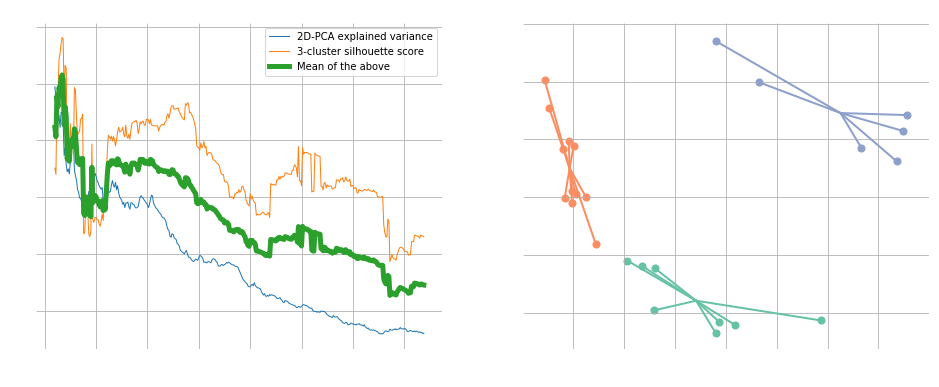

In [12]:
pca_fig

<a id='res'></a>
<hr>
<h2>Results</h2>

<a id='con'></a>
<hr>
<h2>Conclusion</h2>

<a id='ref'></a>
<hr>
<h2>References</h2>